# Dataloaders

In [1]:
# Importing libraries
import torchio as tio
import glob
import numpy as np
import random
import os
import pickle

from collections import OrderedDict
from pathlib import Path

from tqdm import tqdm
import time

import torchio as tio
from torchio.transforms import (RescaleIntensity,RandomFlip,Compose, HistogramStandardization)

from sklearn.metrics import accuracy_score

from torch.utils.data import DataLoader
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

In [2]:
with open('../3_Classifier_training/study_test_design', 'rb') as f:
    study_design = pickle.load(f)

In [3]:
# Torchio's subjects' dictionary
subjects_list={}

for group in study_design.keys():
    subjects_list[group]={}
    for dataset in study_design[group].keys():
        subjects_list[group][dataset]={}
        for types in study_design[group][dataset].keys():
            if types=='other':
                continue
                
            subjects_list[group][dataset][types]=[tio.Subject(chiasm=tio.Image(study_design[group][dataset][types][sub]['chiasm'], type=tio.INTENSITY), label=study_design[group][dataset][types][sub]['class']) for sub in study_design[group][dataset][types].keys()]
            # remove if doesn't exist
            if not subjects_list[group][dataset][types]:
                del subjects_list[group][dataset][types]

In [4]:
# Histogram standardization (to mitigate cross-site differences)
chiasm_paths=[]

# Obtain paths of all chiasm images
for group in study_design.keys():
    #print(group)
    for dataset in study_design[group]:
        #print(dataset)
        for types in study_design[group][dataset]:
            if types != 'other':
                for subjects in study_design[group][dataset][types]:
                    chiasm_paths.append(study_design[group][dataset][types][subjects]['chiasm'])

chiasm_landmarks_path = Path('chiasm_landmarks.npy')    

chiasm_landmarks = HistogramStandardization.train(chiasm_paths)
torch.save(chiasm_landmarks, chiasm_landmarks_path)

landmarks={'chiasm': chiasm_landmarks}

standardize = HistogramStandardization(landmarks)

100%|██████████| 1642/1642 [00:06<00:00, 240.49it/s]


In [5]:
# Data preprocessing and augmentation

# Rescale
rescale = RescaleIntensity((0,1))

# Flip
#flip = RandomFlip((0,1,2), flip_probability=0.5, p=0.5)
flip = RandomFlip((0,1,2), flip_probability=0.5, p=0.5)

# Affine transformations
affine = tio.RandomAffine(degrees=10)

# Elastic deformation
elastic = tio.transforms.RandomElasticDeformation(num_control_points=4, max_displacement=4, locked_borders=1)

# Bias field (???)

# Composing transforms - flip serves as data augmentation and is used only for training
transform_train = Compose([affine, standardize, rescale, flip])

transform_dev = Compose([standardize, rescale])

In [6]:
# Define datasets

# Torchio's subjects' dictionary
datasets_list={}

for group in subjects_list.keys():
    
    datasets_list[group]={}
    
    for dataset in subjects_list[group].keys():
        
        datasets_list[group][dataset]={}
        
        for types in subjects_list[group][dataset].keys():
            
            # Selection of the right transformation
            if (group =='train'):
                applied_transformation = transform_train
            else:
                applied_transformation = transform_dev
            
            #print(group, dataset,types, applied_transformation)
            datasets_list[group][dataset][types]=tio.SubjectsDataset(subjects_list[group][dataset][types], transform = applied_transformation) 

In [7]:
# Concatenate required datasets
concatenated_datasets={}

for group in datasets_list:

    entry=[]
    
    for dataset in datasets_list[group].keys():
    
    
        for types in datasets_list[group][dataset].keys():
            
            #print(group, dataset, types)
            
            entry.append(datasets_list[group][dataset][types])
    
    concatenated_datasets[group]=torch.utils.data.ConcatDataset(entry)

In [8]:
# Create dataloaders
dataloaders_chiasm={'train': DataLoader(dataset=concatenated_datasets['train'], batch_size=10, shuffle=True, num_workers=8),
                   'dev_train': DataLoader(dataset=concatenated_datasets['dev_train'], batch_size=10, shuffle=True, num_workers=8),
                   'dev_test': DataLoader(dataset=concatenated_datasets['dev_test'], batch_size=10, shuffle=True, num_workers=8),
                   'test_1': DataLoader(dataset=concatenated_datasets['test_1'], batch_size=10, shuffle=True, num_workers=8),
                   'test_2': DataLoader(dataset=concatenated_datasets['test_2'], batch_size=10, shuffle=True, num_workers=8),
                   }


## Input sample

train


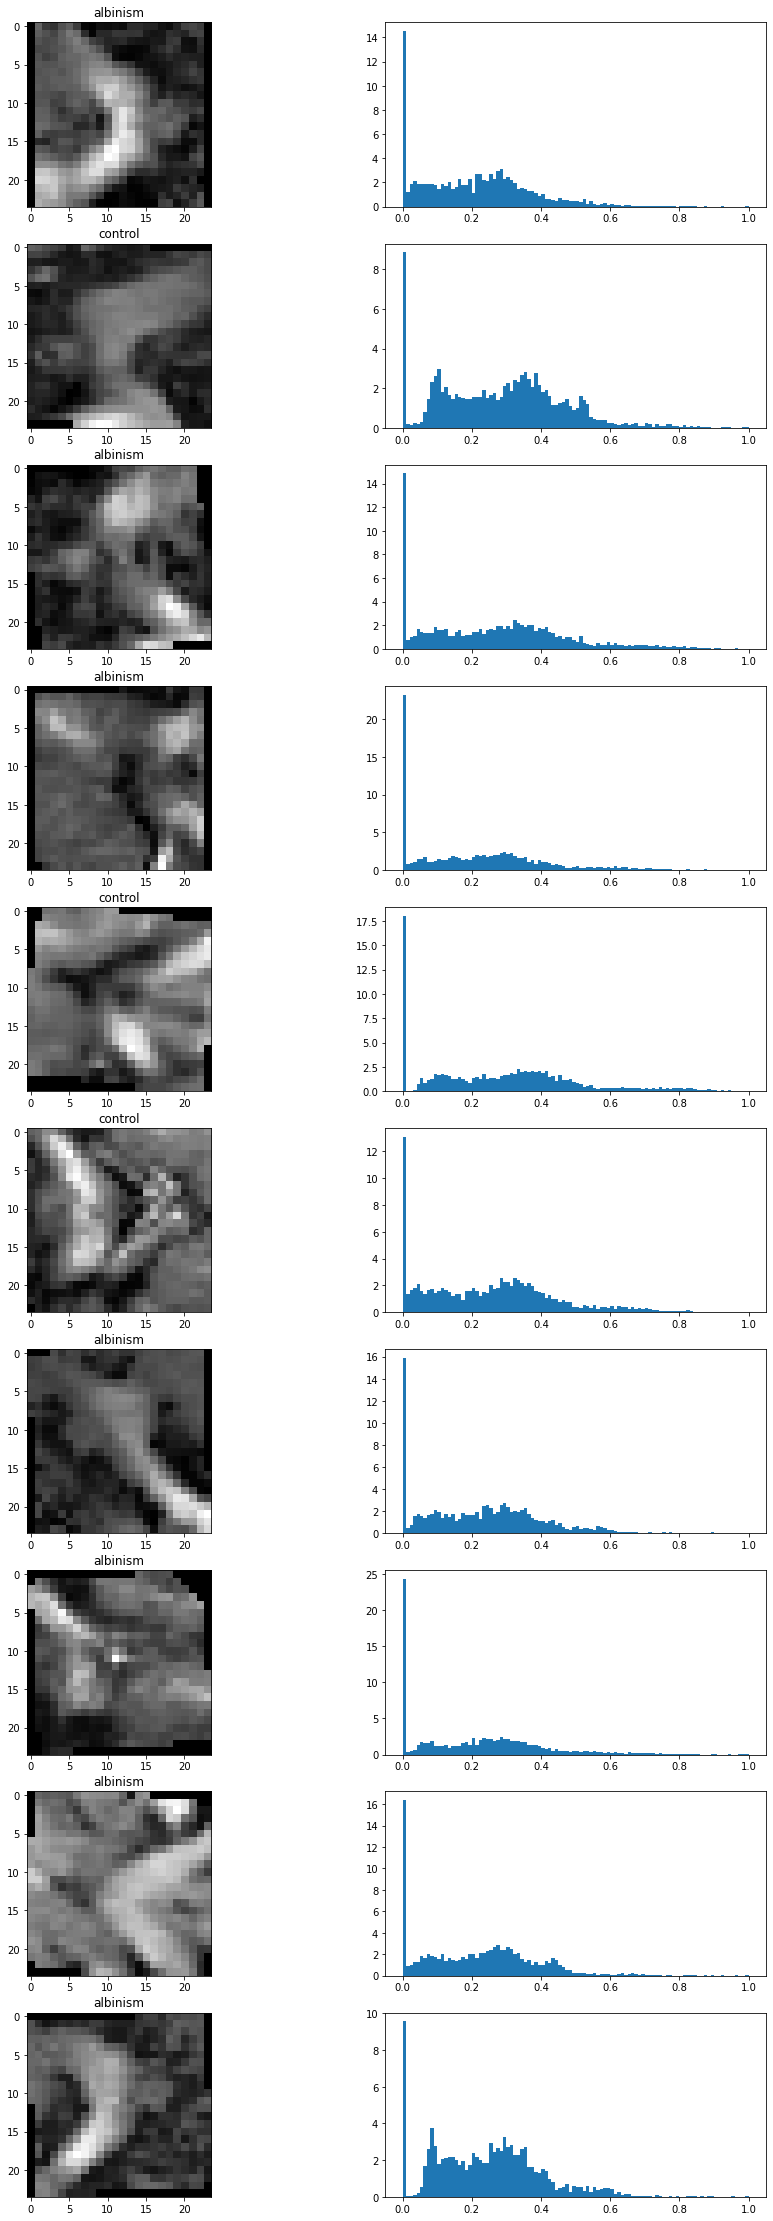

dev_train


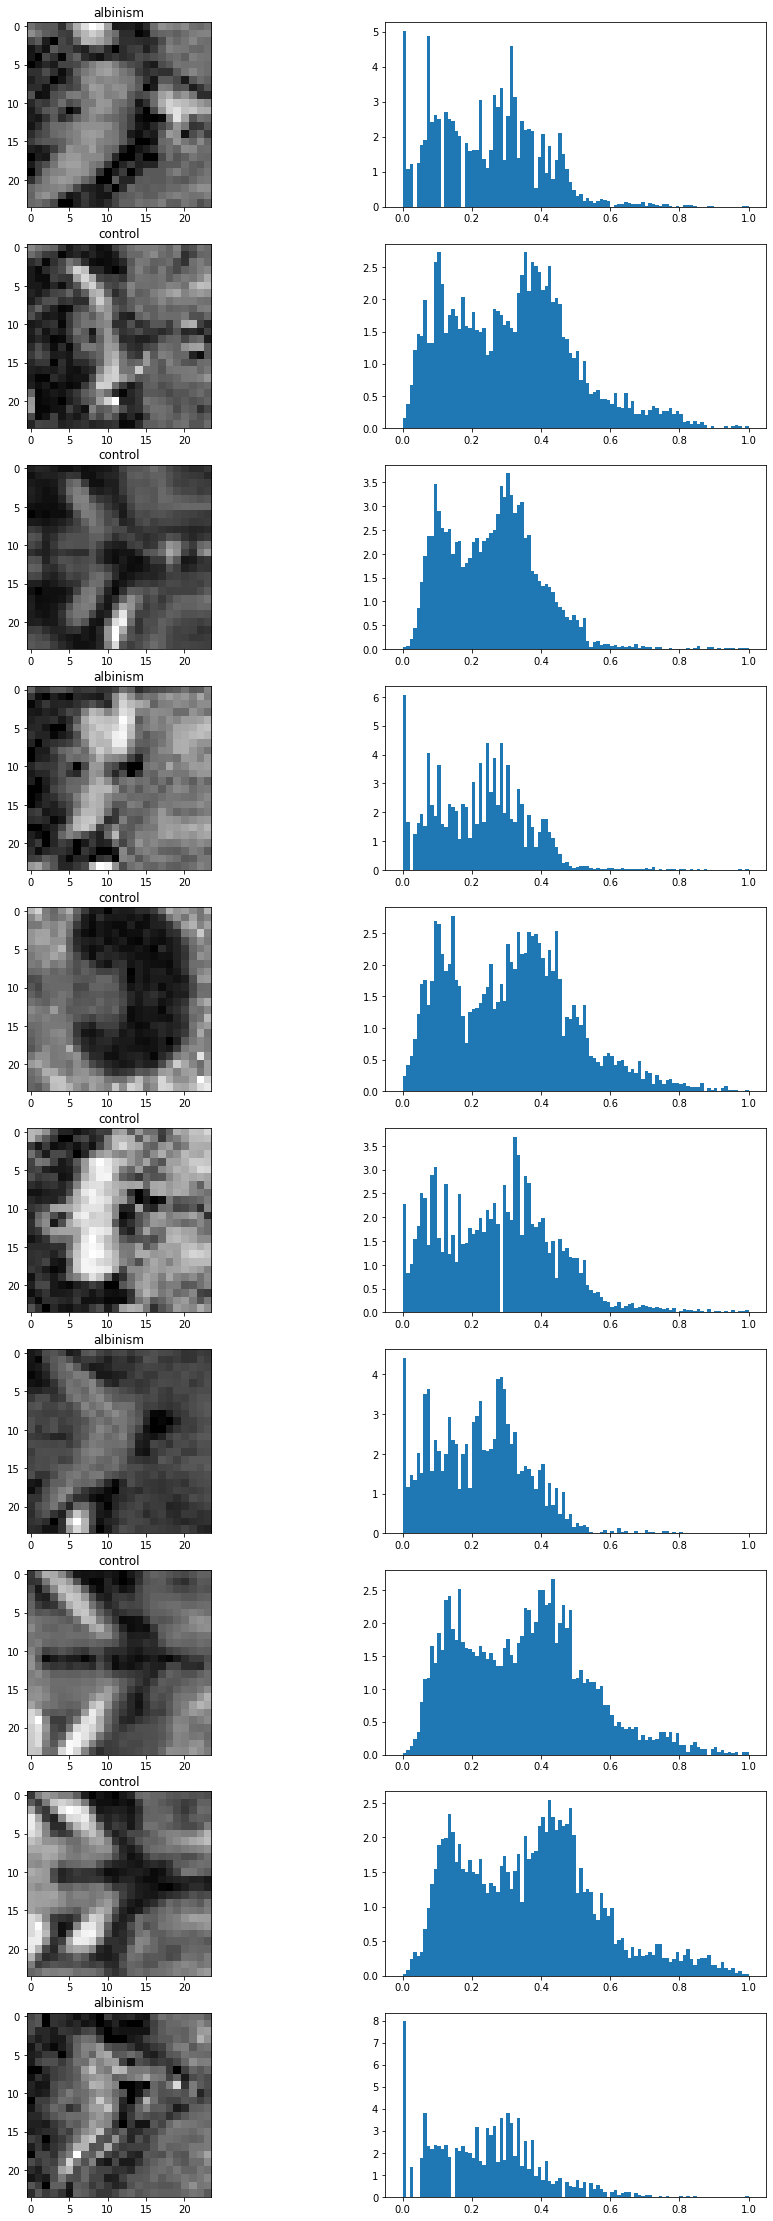

dev_test


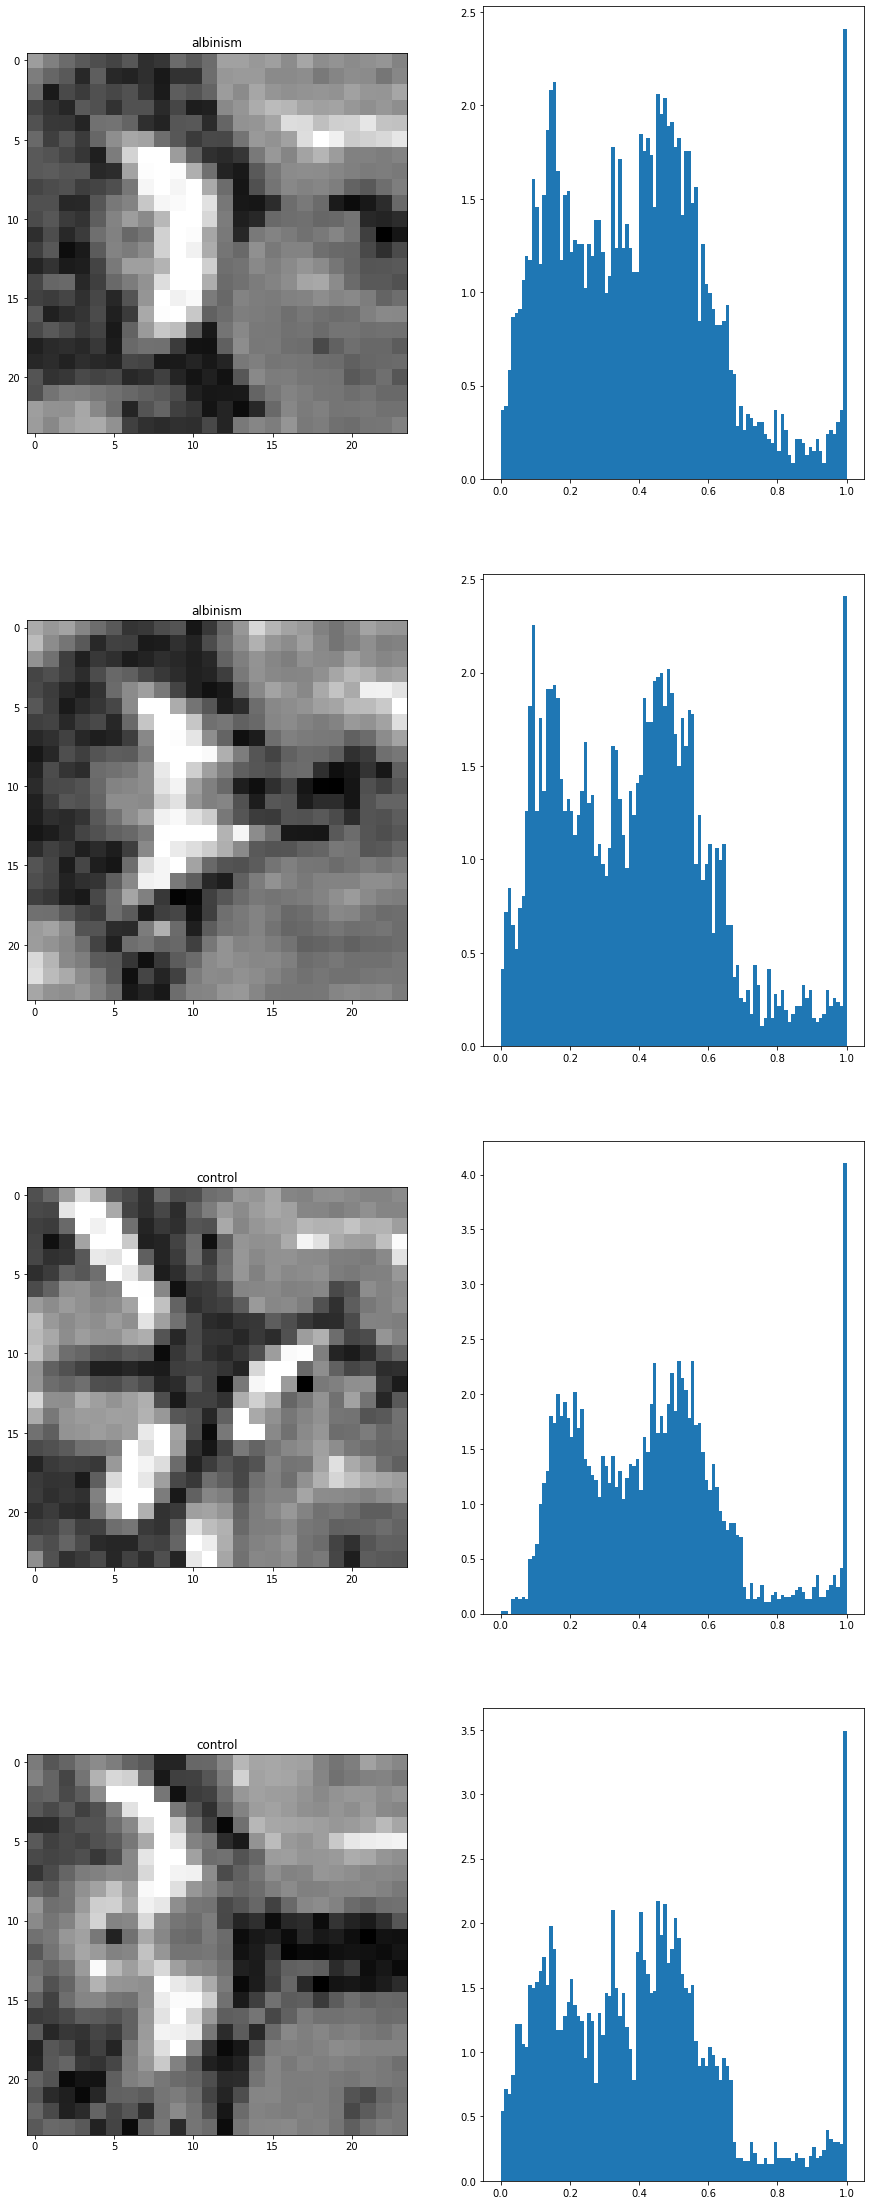

In [9]:
# Visualize results
classes=['control','albinism','other']

for group in ['train', 'dev_train', 'dev_test']:
    
    print(group)
    
    batch = next(enumerate(dataloaders_chiasm[group]))
    
    data = batch[1]['chiasm']['data']
    labels = batch[1]['label']
    
    inputs = data.cpu().numpy()

        
    fig = plt.figure(figsize=(15,40))
    
    for i in range(inputs.shape[0]):
        
        plt.subplot(inputs.shape[0],2,2*i+1)
        plt.imshow(inputs[i,0,:,:,5],cmap='gray');
        plt.title(classes[labels[i]])    
        plt.subplot(inputs.shape[0],2,2*i+2)
        plt.hist(inputs[i,0].reshape(-1),density=True, bins=100);
        plt.axis('on')
    
    plt.show()

## Average input

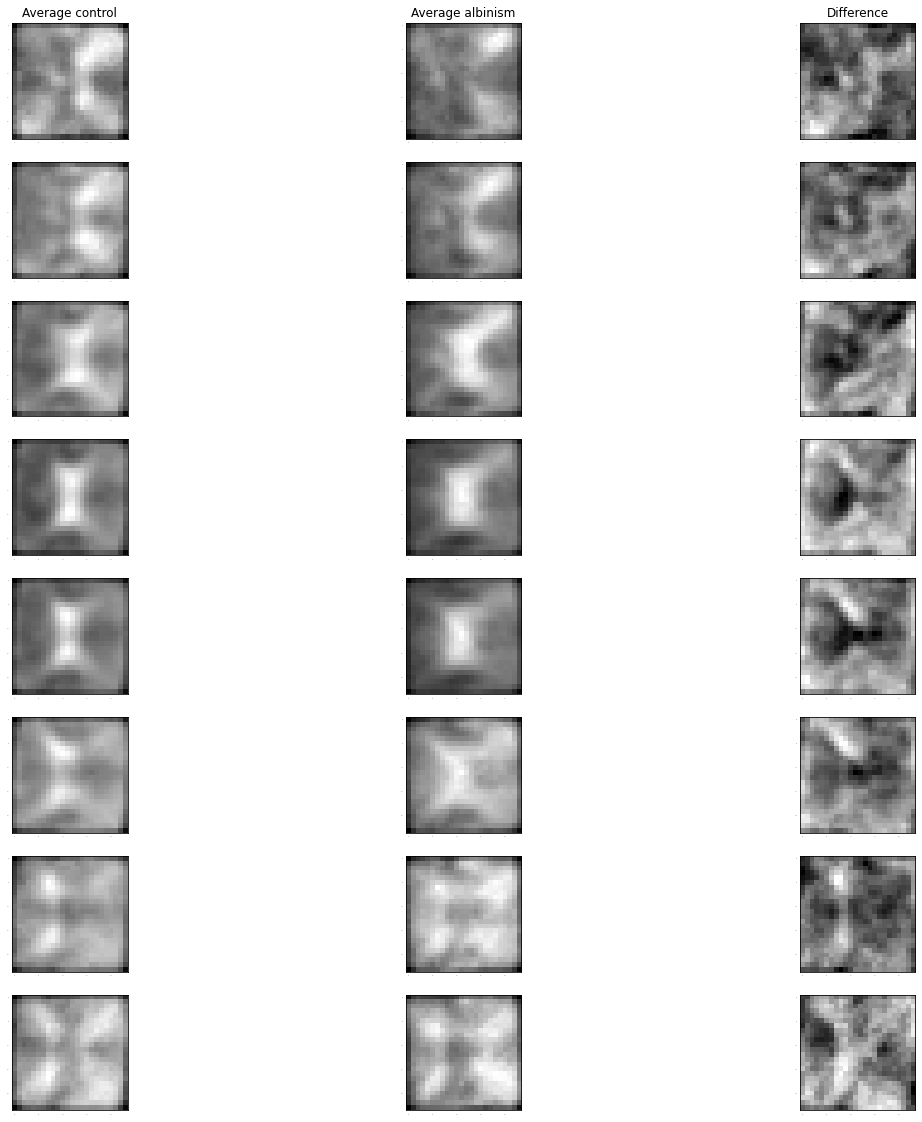

In [10]:
# Calculate average input

average_control=np.zeros((24,24,8))
average_albinism = np.zeros((24,24,8))

for batch in dataloaders_chiasm['train']:    
    average_control+=np.sum(np.array(batch['chiasm']['data'])[batch['label'].numpy()==0], axis=(0,1))
    average_albinism+=np.sum(np.array(batch['chiasm']['data'])[batch['label'].numpy()==1], axis=(0,1))

plt.figure(figsize=(20,20))

for i in range(8):
        
    # Control
    plt.subplot(8,3,3*i+1)
    plt.imshow(average_control[:,:,i], cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if(i==0):
        plt.title('Average control')
    
    # Albinism
    plt.subplot(8,3,3*i+2)
    plt.imshow(average_albinism[:,:,i], cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if(i==0):
        plt.title('Average albinism')
        
    # Difference control - albinism
    plt.subplot(8,3,3*i+3)
    plt.imshow(average_control[:,:,i]-average_albinism[:,:,i], cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if(i==0):
        plt.title('Difference')

## Average encoded input

In [11]:
# Calculate average input after AE step
'''
ae = UNet(1,1,32,1)
ae.load_state_dict(torch.load('../../1_Data/2_Trained_AE/32_1/optimal_weights'))

average_control=np.zeros((24,24,8))
average_albinism = np.zeros((24,24,8))

for batch in dataloaders_chiasm['train']:  
                              
    output = ae(batch['chiasm']['data']).detach().numpy()                
                                                       
    average_control+=np.sum(output[batch['label'].numpy()==0], axis=(0,1))
    average_albinism+=np.sum(output[batch['label'].numpy()==1], axis=(0,1))

plt.figure(figsize=(20,20))

for i in range(8):
        
    # Control
    plt.subplot(8,2,2*i+1)
    plt.imshow(average_control[:,:,i], cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if(i==0):
        plt.title('Average control')
    
    # Albinism
    plt.subplot(8,2,2*i+2)
    plt.imshow(average_albinism[:,:,i], cmap='gray')
    plt.tick_params(axis='both', labelsize=0, length = 0)
    if(i==0):
        plt.title('Average albinism')
'''

"\nae = UNet(1,1,32,1)\nae.load_state_dict(torch.load('../../1_Data/2_Trained_AE/32_1/optimal_weights'))\n\naverage_control=np.zeros((24,24,8))\naverage_albinism = np.zeros((24,24,8))\n\nfor batch in dataloaders_chiasm['train']:  \n                              \n    output = ae(batch['chiasm']['data']).detach().numpy()                \n                                                       \n    average_control+=np.sum(output[batch['label'].numpy()==0], axis=(0,1))\n    average_albinism+=np.sum(output[batch['label'].numpy()==1], axis=(0,1))\n\nplt.figure(figsize=(20,20))\n\nfor i in range(8):\n        \n    # Control\n    plt.subplot(8,2,2*i+1)\n    plt.imshow(average_control[:,:,i], cmap='gray')\n    plt.tick_params(axis='both', labelsize=0, length = 0)\n    if(i==0):\n        plt.title('Average control')\n    \n    # Albinism\n    plt.subplot(8,2,2*i+2)\n    plt.imshow(average_albinism[:,:,i], cmap='gray')\n    plt.tick_params(axis='both', labelsize=0, length = 0)\n    if(i==0):\n  

# Network

In [12]:
# Cropped U-Net copied from Overfitting Model

class UNet(nn.Module):
    
    def __init__(self, in_channels=1, out_channels=1, init_features=10, scaling=2):
        super(UNet, self).__init__()
                
        # Encoding layers
        self.encoder1 = self.unet_block(in_channels, init_features, "enc1")
        self.pool1 = nn.AvgPool3d(kernel_size=2, stride=2, padding=0)
        self.encoder2 = self.unet_block(init_features, init_features*scaling, name='enc2')
        self.pool2 = nn.AvgPool3d(kernel_size=2, stride=2, padding=0)

        # Bottleneck layer
        self.bottleneck = self.unet_block(init_features*scaling, init_features*scaling**2, name='bottleneck')
        
        # Decoding layers (where merge with prevois encoding layers occurs)        
        self.upconv2 = nn.ConvTranspose3d(init_features*scaling**2, init_features*scaling, kernel_size=2, stride=2)
        self.decoder2 = self.unet_block(init_features*scaling, init_features*scaling, name='dec2')
                
        self.upconv1 = nn.ConvTranspose3d(init_features*scaling, init_features, kernel_size=2, stride=2)
        self.decoder1 = self.unet_block(init_features, init_features, name='dec1')
        
        # Final convolution - output equals number of output channels
        self.conv = nn.Conv3d(init_features, out_channels, kernel_size=1) 
        
    def forward(self,x):
        
        # Encoding
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool2(enc2))

        # Upconvolving, concatenating data from respective encoding phase and executing UNet block
        dec2 = self.upconv2(bottleneck)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = self.decoder1(dec1)
        
        out_conv = self.conv(dec1)
        
        return torch.sigmoid(out_conv)
    
    def unet_block(self, in_channels, features, name):
        
        return nn.Sequential(OrderedDict([(name+'conv1',nn.Conv3d(in_channels=in_channels, out_channels=features, kernel_size=3, padding=1, bias=False)),
                             (name+'bnorm1', nn.BatchNorm3d(num_features=features)),
                             (name+'relu1', nn.ReLU(inplace=True)),
                             (name+'conv2', nn.Conv3d(in_channels=features, out_channels=features, kernel_size=3, padding=1, bias=False)),
                             (name+'bnorm2', nn.BatchNorm3d(num_features=features)),
                             (name+'relu2', nn.ReLU(inplace=True))])
                            )

    def output_latent_representations(self,x):
        
        print(x.shape)

        # Encoding
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool2(enc2))
        
        print(bottleneck.shape)
        
        return bottleneck

In [13]:
class Classify_chiasm(nn.Module):
    
    def __init__(self, init_features, scaling, num_fc_layers, num_hidden_nodes, weights_path='../../1_Data/2_Trained_AE/'):
        super(Classify_chiasm, self).__init__()
        
        self.init_features = init_features
        self.scaling = scaling
        self.num_fc_layers = num_fc_layers
        self.num_hidden_nodes = num_hidden_nodes
        
        # Initialize the network_extracting_features and load its weights
        network_extracting_features = UNet(1,1,init_features,scaling)
        network_extracting_features.load_state_dict(torch.load(weights_path+'/'+str(init_features)+'_'+str(scaling)+'/optimal_weights'))
        
        child = network_extracting_features.children()
        
        # Copying the desired components (analysis stream) from network_extracting_features
        self.feature_extraction = nn.Sequential(*list(child)[:5])
        
        # Classification layers
        if self.num_fc_layers==0:
            self.classifier = nn.Linear(self.init_features*(self.scaling**2)*6*6*2,3)
        elif self.num_fc_layers==1:
            self.classifier = nn.Sequential(nn.Linear(self.init_features*(self.scaling**2)*6*6*2,self.num_hidden_nodes),nn.ReLU(),nn.Linear(self.num_hidden_nodes,3))
        
        # Placeholder for gradients
        self.gradients = None
    
    # Freeze all the layers apart from the classifying one
    def freeze_feature_extraction(self):
        
        counter = 0
        for layer in classifying_network.children():
            counter += 1
            if counter < 2:
                #print(layer)
                for param in layer.parameters():
                    param.requires_grad = False
                    
    # Freeze feature selection layers only
    def freeze_classification(self):
        
        counter = 0
        for layer in classifying_network.children():
            counter += 1
            if counter == 2:
                #print(layer)
                for param in layer.parameters():
                    param.requires_grad = False
            
    # Hook for the activations' gradients
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self,x):
        
        # To ensure that gradients will be tracked
        #x.requires_grad = True
        
        # Feature extraction
        x = self.feature_extraction(x)
        
        # Register the hook
        if self.train and x.requires_grad:
            h = x.register_hook(self.activations_hook)

        # Flatten the image
        #x = torch.flatten(x, start_dim=1)
        x = x.view((x.shape[0], -1))        

        # Classifying FC layer and activation function
        x = self.classifier(x)
        
        return torch.softmax(x, dim=1)

    # Output latent representations (or activations) of the last CNN layer
    def output_latent_representations(self,x):        
        return self.feature_extraction(x)     
    
    # Output gradient
    def output_activation_gradient(self):
        return self.gradients
    
    def gradcam_backup(self, x):
        
        # Calculate prediction
        pred = self.forward(x)
        
        # Get the gradient from the prediction
        pred.backward()
         
        # Extract the gradients from final layer extracting features
        gradients = self.output_activation_gradient()
        print(gradients.shape)
        
        # Pool the gradients
        pooled_gradients = torch.mean(gradients, dim=[0,2,3,4])
        
        # Extract activations
        activations = self.output_latent_representations(x).detach()
        
        # Weight activations by the gradients
        activations[:, i, :, :, :] *= pooled_gradients[i]
        
        # Average the channels of the activations
        heatmap = torch.mean(activations, dim=1).squeeze()
        
        heatmap = np.maximum(heatmap, 0)
        
        heatmap /= torch.max(heatmap)
        
        return heatmap    
        
    def gradcam(self, x, class_id):

        # Calculate prediction
        pred = self.forward(x)

        # Get the gradient from the prediction
        pred[:,class_id].backward()

        # Extract the gradients from final layer extracting features
        gradients = self.output_activation_gradient()
        print(gradients.shape)

        # Pool the gradients
        pooled_gradients = torch.mean(gradients, dim=[0,2,3,4])

        # Extract activations
        activations = self.output_latent_representations(x).detach()

        # Weight activations by the gradients
        for i in range(self.init_features * self.scaling**2):
            activations[:, i, :, :, :] *= pooled_gradients[i]

        # Average the channels of the activations
        heatmap = torch.mean(activations, dim=1).squeeze()

        heatmap = np.maximum(heatmap, 0)

        heatmap /= torch.max(heatmap)

        return heatmap    

# Training

In [14]:
# Try setting CUDA if possible
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu") 
    
print(device)

cuda


In [15]:
# Criterion
criterion = nn.NLLLoss()
#criterion = nn.BCELoss()

In [16]:
# Function returning trained model
def train_network(n_epochs, dataloaders, model, optimizer, criterion, device, save_path):
    
    track_train_loss = []
    track_dev_train_loss = []
    track_dev_test_loss = []
    
    track_train_acc = []
    track_dev_train_acc = []
    track_dev_test_acc = []
    
    valid_loss_min = np.Inf
    
    model.to(device)
        
    for epoch in tqdm(range(1, n_epochs+1)):
        
        # Initialize loss monitoring variables
        train_loss = 0.0
        dev_train_loss = 0.0
        dev_test_loss = 0.0
                
        # Training
        model.train()
        
        acc_targets=[]
        acc_predictions=[]
        
        for batch in dataloaders['train']:
            
            data = batch['chiasm']['data'].to(device)
            data.requires_grad = True
            
            optimizer.zero_grad()
            
            output=model(data)
            
            loss = criterion(output, batch['label'].to(device))
            loss.backward()
            
            optimizer.step()
            
            train_loss+= (loss.item()*len(batch['label']))
            
            acc_targets+=batch['label'][:].numpy().tolist()
            acc_predictions+=output.argmax(dim=1).cpu().numpy().tolist()
            
        track_train_loss.append(train_loss/len(concatenated_datasets['train']))        
        track_train_acc.append(accuracy_score(acc_targets, acc_predictions)) 
            
        # Validation on two datasets
        model.eval()
        
        acc_targets=[]
        acc_predictions=[]
        
        for batch in dataloaders['dev_train']:
            
            data = batch['chiasm']['data'].to(device)
            data.requires_grad = True
            
            with torch.no_grad():
                
                output = model(data)
                loss = criterion(output, batch['label'].to(device))
                
                dev_train_loss+= (loss.item()*len(batch['label']))
                
                acc_targets+=batch['label'][:].numpy().tolist()
                acc_predictions+=output.argmax(dim=1).cpu().numpy().tolist()
                
        track_dev_train_loss.append(dev_train_loss/len(concatenated_datasets['dev_train']))
        track_dev_train_acc.append(accuracy_score(acc_targets, acc_predictions)) 
        
        acc_targets=[]
        acc_predictions=[]
        
        for batch in dataloaders['dev_test']:
            
            data = batch['chiasm']['data'].to(device)
            data.requires_grad = True
            
            with torch.no_grad():
                
                output = model(data)
                loss = criterion(output, batch['label'].to(device))
                
                dev_test_loss+= (loss.item()*len(batch['label']))
                
                acc_targets+=batch['label'][:].numpy().tolist()
                acc_predictions+=output.argmax(dim=1).cpu().numpy().tolist()
                
        track_dev_test_loss.append(dev_test_loss/len(concatenated_datasets['dev_test']))
        track_dev_test_acc.append(accuracy_score(acc_targets, acc_predictions)) 
        
        if epoch%1000 ==0:
            print('END OF EPOCH: {} \n Training loss per image: {:.6f}\n Training_dev loss per image: {:.6f}\n Test_dev loss per image: {:.6f}'.format(epoch, train_loss/len(concatenated_datasets['train']),dev_train_loss/len(concatenated_datasets['dev_train']),dev_test_loss/len(concatenated_datasets['dev_test'])))
            
        ## Save the model if reached min validation loss and save the number of epoch               
        if dev_train_loss < valid_loss_min:
            valid_loss_min = dev_train_loss
            torch.save(model.state_dict(),save_path+'optimal_weights')
            last_updated_epoch = epoch
        
            with open(save_path+'number_epochs.txt','w') as f:
                print('Epoch:', str(epoch), file=f)  
                
        # Early stopping
        if (epoch - last_updated_epoch) == 2000:
            break
                                
    # return trained model
    return track_train_loss, track_dev_train_loss, track_dev_test_loss, track_train_acc, track_dev_train_acc, track_dev_test_acc

### Training classification layers only

In [17]:
model_parameters=[[8,2,0,0],[32,1,0,0], [8,2,1,32], [32,1,1,32]]#
learning_rates = [0.0001,0.00001,0.000001]

n_epochs=10000

folder='../../1_Data/3_Trained_classifier_finetuning_classification/'

for parameters in model_parameters:
    for learning_rate in learning_rates:

        # Initialize the proper model
        classifying_network = Classify_chiasm(parameters[0],parameters[1], parameters[2], parameters[3])
        classifying_network.freeze_feature_extraction()

        # Optimizer    
        optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, classifying_network.parameters()), lr=learning_rate)
        #optimizer = torch.optim.Adam(params=classifying_network.parameters(), lr=0.00005)

        # Create output folder
        data_folder = folder+'/'+str(parameters[0])+'_'+str(parameters[1])+'_'+str(parameters[2])+'_'+str(parameters[3])+'_'+str(learning_rate)+'/'
        os.makedirs(data_folder, exist_ok=True)

        # Train & save weights
        train_loss, dev_train_loss, dev_test_loss, train_acc, dev_train_acc, dev_test_acc = train_network(n_epochs, dataloaders_chiasm, classifying_network, optimizer, criterion, device, data_folder)

        # Save losses
        with open(data_folder+'train_loss.pkl', 'wb') as f:
            pickle.dump(train_loss, f)

        with open(data_folder+'dev_train_loss.pkl', 'wb') as f:
            pickle.dump(dev_train_loss, f)

        with open(data_folder+'dev_test_loss.pkl', 'wb') as f:
            pickle.dump(dev_test_loss, f)

        with open(data_folder+'train_acc.pkl', 'wb') as f:
            pickle.dump(train_acc, f)

        with open(data_folder+'dev_train_acc.pkl', 'wb') as f:
            pickle.dump(dev_train_acc, f)

        with open(data_folder+'dev_test_acc.pkl', 'wb') as f:
            pickle.dump(dev_test_acc, f)

 10%|█         | 1000/10000 [13:07<1:55:05,  1.30it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.911122
 Training_dev loss per image: -0.838504
 Test_dev loss per image: -0.500975


 20%|██        | 2000/10000 [27:24<1:53:22,  1.18it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.937945
 Training_dev loss per image: -0.772026
 Test_dev loss per image: -0.500138


 10%|█         | 1000/10000 [13:42<1:57:57,  1.27it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.832615
 Training_dev loss per image: -0.814596
 Test_dev loss per image: -0.527266


 20%|██        | 2000/10000 [27:10<1:49:25,  1.22it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.833392
 Training_dev loss per image: -0.833273
 Test_dev loss per image: -0.518184


 30%|███       | 3000/10000 [40:34<1:37:34,  1.20it/s]

END OF EPOCH: 3000 
 Training loss per image: -0.860566
 Training_dev loss per image: -0.840199
 Test_dev loss per image: -0.515510


 40%|████      | 4000/10000 [54:14<1:17:48,  1.29it/s]

END OF EPOCH: 4000 
 Training loss per image: -0.861910
 Training_dev loss per image: -0.831994
 Test_dev loss per image: -0.507720


 50%|█████     | 5000/10000 [1:08:21<1:13:01,  1.14it/s]

END OF EPOCH: 5000 
 Training loss per image: -0.893296
 Training_dev loss per image: -0.846250
 Test_dev loss per image: -0.504984


 60%|██████    | 6000/10000 [1:22:09<52:45,  1.26it/s]  

END OF EPOCH: 6000 
 Training loss per image: -0.885010
 Training_dev loss per image: -0.844004
 Test_dev loss per image: -0.505609


 70%|███████   | 7000/10000 [1:35:33<39:08,  1.28it/s]

END OF EPOCH: 7000 
 Training loss per image: -0.879918
 Training_dev loss per image: -0.846780
 Test_dev loss per image: -0.502560


 10%|█         | 1000/10000 [13:02<1:56:59,  1.28it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.632881
 Training_dev loss per image: -0.686632
 Test_dev loss per image: -0.505451


 20%|██        | 2000/10000 [26:03<1:43:55,  1.28it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.656387
 Training_dev loss per image: -0.734880
 Test_dev loss per image: -0.505252


 30%|███       | 3000/10000 [39:07<1:34:31,  1.23it/s]

END OF EPOCH: 3000 
 Training loss per image: -0.743851
 Training_dev loss per image: -0.746316
 Test_dev loss per image: -0.505129


 40%|████      | 4000/10000 [52:51<1:24:49,  1.18it/s]

END OF EPOCH: 4000 
 Training loss per image: -0.725898
 Training_dev loss per image: -0.758907
 Test_dev loss per image: -0.506792


 50%|█████     | 5000/10000 [1:06:06<1:09:45,  1.19it/s]

END OF EPOCH: 5000 
 Training loss per image: -0.780622
 Training_dev loss per image: -0.766638
 Test_dev loss per image: -0.509221


 60%|██████    | 6000/10000 [1:19:38<52:08,  1.28it/s]  

END OF EPOCH: 6000 
 Training loss per image: -0.785270
 Training_dev loss per image: -0.776465
 Test_dev loss per image: -0.511455


 70%|███████   | 7000/10000 [1:32:45<39:14,  1.27it/s]

END OF EPOCH: 7000 
 Training loss per image: -0.794941
 Training_dev loss per image: -0.782697
 Test_dev loss per image: -0.513608


 80%|████████  | 8000/10000 [1:46:41<29:17,  1.14it/s]

END OF EPOCH: 8000 
 Training loss per image: -0.798469
 Training_dev loss per image: -0.792197
 Test_dev loss per image: -0.515211


 90%|█████████ | 9000/10000 [2:00:39<13:27,  1.24it/s]

END OF EPOCH: 9000 
 Training loss per image: -0.794880
 Training_dev loss per image: -0.783880
 Test_dev loss per image: -0.512094


  0%|          | 0/10000 [00:00<?, ?it/s]

END OF EPOCH: 10000 
 Training loss per image: -0.828227
 Training_dev loss per image: -0.786757
 Test_dev loss per image: -0.510691


 10%|█         | 1000/10000 [13:31<2:00:00,  1.25it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.894338
 Training_dev loss per image: -0.696670
 Test_dev loss per image: -0.500807


 20%|██        | 2000/10000 [27:07<1:54:30,  1.16it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.907497
 Training_dev loss per image: -0.780478
 Test_dev loss per image: -0.500281


 30%|███       | 3000/10000 [40:52<1:33:33,  1.25it/s]

END OF EPOCH: 3000 
 Training loss per image: -0.932337
 Training_dev loss per image: -0.677538
 Test_dev loss per image: -0.500015


 10%|█         | 1000/10000 [13:41<2:04:49,  1.20it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.757920
 Training_dev loss per image: -0.755120
 Test_dev loss per image: -0.517237


 20%|██        | 2000/10000 [27:41<1:51:12,  1.20it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.821424
 Training_dev loss per image: -0.733609
 Test_dev loss per image: -0.530586


 30%|███       | 3000/10000 [41:23<1:35:00,  1.23it/s]

END OF EPOCH: 3000 
 Training loss per image: -0.829230
 Training_dev loss per image: -0.755441
 Test_dev loss per image: -0.511582


 10%|█         | 1000/10000 [13:49<2:06:03,  1.19it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.631207
 Training_dev loss per image: -0.632767
 Test_dev loss per image: -0.522802


 20%|██        | 2000/10000 [27:10<1:47:00,  1.25it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.648726
 Training_dev loss per image: -0.699584
 Test_dev loss per image: -0.535875


 30%|███       | 3000/10000 [40:30<1:32:25,  1.26it/s]

END OF EPOCH: 3000 
 Training loss per image: -0.692346
 Training_dev loss per image: -0.727093
 Test_dev loss per image: -0.519021


 40%|████      | 4000/10000 [53:49<1:20:09,  1.25it/s]

END OF EPOCH: 4000 
 Training loss per image: -0.687776
 Training_dev loss per image: -0.747654
 Test_dev loss per image: -0.533345


 50%|█████     | 5000/10000 [1:07:07<1:06:04,  1.26it/s]

END OF EPOCH: 5000 
 Training loss per image: -0.702544
 Training_dev loss per image: -0.755980
 Test_dev loss per image: -0.520829


 60%|██████    | 6000/10000 [1:20:34<53:29,  1.25it/s]  

END OF EPOCH: 6000 
 Training loss per image: -0.755812
 Training_dev loss per image: -0.760260
 Test_dev loss per image: -0.515569


 70%|███████   | 7000/10000 [1:33:57<39:54,  1.25it/s]

END OF EPOCH: 7000 
 Training loss per image: -0.746982
 Training_dev loss per image: -0.755062
 Test_dev loss per image: -0.528388


 80%|████████  | 8000/10000 [1:47:19<26:40,  1.25it/s]

END OF EPOCH: 8000 
 Training loss per image: -0.744582
 Training_dev loss per image: -0.759895
 Test_dev loss per image: -0.535849


 10%|█         | 1000/10000 [13:16<1:59:18,  1.26it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.913226
 Training_dev loss per image: -0.722774
 Test_dev loss per image: -0.500001


 20%|██        | 2000/10000 [26:33<1:45:56,  1.26it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.958304
 Training_dev loss per image: -0.773849
 Test_dev loss per image: -0.500000


 10%|█         | 1000/10000 [13:19<1:59:25,  1.26it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.861261
 Training_dev loss per image: -0.851352
 Test_dev loss per image: -0.521246


 20%|██        | 2000/10000 [26:38<1:48:43,  1.23it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.888197
 Training_dev loss per image: -0.839544
 Test_dev loss per image: -0.503891


 30%|███       | 3000/10000 [40:16<1:36:06,  1.21it/s]

END OF EPOCH: 3000 
 Training loss per image: -0.916137
 Training_dev loss per image: -0.834452
 Test_dev loss per image: -0.500474


 40%|████      | 4000/10000 [53:54<1:21:58,  1.22it/s]

END OF EPOCH: 4000 
 Training loss per image: -0.919410
 Training_dev loss per image: -0.831913
 Test_dev loss per image: -0.500216


 10%|█         | 1000/10000 [13:38<2:02:35,  1.22it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.679380
 Training_dev loss per image: -0.717913
 Test_dev loss per image: -0.517142


 20%|██        | 2000/10000 [27:16<1:48:28,  1.23it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.757463
 Training_dev loss per image: -0.741922
 Test_dev loss per image: -0.512574


 30%|███       | 3000/10000 [40:53<1:35:06,  1.23it/s]

END OF EPOCH: 3000 
 Training loss per image: -0.781984
 Training_dev loss per image: -0.763552
 Test_dev loss per image: -0.516730


 40%|████      | 4000/10000 [54:29<1:21:06,  1.23it/s]

END OF EPOCH: 4000 
 Training loss per image: -0.814242
 Training_dev loss per image: -0.803448
 Test_dev loss per image: -0.527428


 50%|█████     | 5000/10000 [1:08:05<1:07:58,  1.23it/s]

END OF EPOCH: 5000 
 Training loss per image: -0.821336
 Training_dev loss per image: -0.818225
 Test_dev loss per image: -0.525875


 60%|██████    | 6000/10000 [1:21:41<53:59,  1.23it/s]  

END OF EPOCH: 6000 
 Training loss per image: -0.839773
 Training_dev loss per image: -0.822577
 Test_dev loss per image: -0.523629


 70%|███████   | 7000/10000 [1:35:16<40:27,  1.24it/s]

END OF EPOCH: 7000 
 Training loss per image: -0.831739
 Training_dev loss per image: -0.832789
 Test_dev loss per image: -0.520730


 80%|████████  | 8000/10000 [1:48:52<27:17,  1.22it/s]

END OF EPOCH: 8000 
 Training loss per image: -0.843276
 Training_dev loss per image: -0.829352
 Test_dev loss per image: -0.515433


 90%|█████████ | 9000/10000 [2:02:27<13:35,  1.23it/s]

END OF EPOCH: 9000 
 Training loss per image: -0.872704
 Training_dev loss per image: -0.833159
 Test_dev loss per image: -0.514385


  0%|          | 0/10000 [00:00<?, ?it/s]

END OF EPOCH: 10000 
 Training loss per image: -0.890498
 Training_dev loss per image: -0.833688
 Test_dev loss per image: -0.508515


 10%|█         | 1000/10000 [13:45<2:04:00,  1.21it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.916830
 Training_dev loss per image: -0.752715
 Test_dev loss per image: -0.500002


 20%|██        | 2000/10000 [27:28<1:50:14,  1.21it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.936831
 Training_dev loss per image: -0.592072
 Test_dev loss per image: -0.500000


 30%|███       | 3000/10000 [41:13<1:36:58,  1.20it/s]

END OF EPOCH: 3000 
 Training loss per image: -0.953565
 Training_dev loss per image: -0.582962
 Test_dev loss per image: -0.500000


 40%|████      | 4000/10000 [54:58<1:22:45,  1.21it/s]

END OF EPOCH: 4000 
 Training loss per image: -0.970978
 Training_dev loss per image: -0.805308
 Test_dev loss per image: -0.500000


 50%|█████     | 5000/10000 [1:08:43<1:08:24,  1.22it/s]

END OF EPOCH: 5000 
 Training loss per image: -0.949695
 Training_dev loss per image: -0.721717
 Test_dev loss per image: -0.500000


 60%|██████    | 6000/10000 [1:22:28<54:41,  1.22it/s]  

END OF EPOCH: 6000 
 Training loss per image: -0.972623
 Training_dev loss per image: -0.659986
 Test_dev loss per image: -0.500000


 70%|███████   | 7000/10000 [1:36:13<41:46,  1.20it/s]

END OF EPOCH: 7000 
 Training loss per image: -0.946176
 Training_dev loss per image: -0.637248
 Test_dev loss per image: -0.500000


 80%|████████  | 8000/10000 [1:49:57<27:36,  1.21it/s]

END OF EPOCH: 8000 
 Training loss per image: -0.980068
 Training_dev loss per image: -0.660299
 Test_dev loss per image: -0.500000


 90%|█████████ | 9000/10000 [2:03:43<13:51,  1.20it/s]

END OF EPOCH: 9000 
 Training loss per image: -0.973375
 Training_dev loss per image: -0.604652
 Test_dev loss per image: -0.500000


 10%|█         | 1000/10000 [13:43<2:03:29,  1.21it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.813473
 Training_dev loss per image: -0.758698
 Test_dev loss per image: -0.513141


 20%|██        | 2000/10000 [27:27<1:49:45,  1.21it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.866036
 Training_dev loss per image: -0.750170
 Test_dev loss per image: -0.502583


 30%|███       | 3000/10000 [41:13<1:36:32,  1.21it/s]

END OF EPOCH: 3000 
 Training loss per image: -0.903940
 Training_dev loss per image: -0.747383
 Test_dev loss per image: -0.500171


 40%|████      | 4000/10000 [54:57<1:22:14,  1.22it/s]

END OF EPOCH: 4000 
 Training loss per image: -0.905708
 Training_dev loss per image: -0.683235
 Test_dev loss per image: -0.500010


 50%|█████     | 5000/10000 [1:08:41<1:08:35,  1.22it/s]

END OF EPOCH: 5000 
 Training loss per image: -0.917599
 Training_dev loss per image: -0.698158
 Test_dev loss per image: -0.500002


 10%|█         | 1000/10000 [13:47<2:04:05,  1.21it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.624980
 Training_dev loss per image: -0.663892
 Test_dev loss per image: -0.549379


 20%|██        | 2000/10000 [27:33<1:49:51,  1.21it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.667704
 Training_dev loss per image: -0.709703
 Test_dev loss per image: -0.533521


 30%|███       | 3000/10000 [41:22<1:37:00,  1.20it/s]

END OF EPOCH: 3000 
 Training loss per image: -0.706775
 Training_dev loss per image: -0.748855
 Test_dev loss per image: -0.522876


 40%|████      | 4000/10000 [55:08<1:21:58,  1.22it/s]

END OF EPOCH: 4000 
 Training loss per image: -0.725188
 Training_dev loss per image: -0.762230
 Test_dev loss per image: -0.516147


 50%|█████     | 5000/10000 [1:08:54<1:08:53,  1.21it/s]

END OF EPOCH: 5000 
 Training loss per image: -0.758568
 Training_dev loss per image: -0.768943
 Test_dev loss per image: -0.520772


 60%|██████    | 6000/10000 [1:22:41<55:04,  1.21it/s]  

END OF EPOCH: 6000 
 Training loss per image: -0.776427
 Training_dev loss per image: -0.765668
 Test_dev loss per image: -0.526334


 70%|███████   | 7000/10000 [1:36:26<41:27,  1.21it/s]

END OF EPOCH: 7000 
 Training loss per image: -0.794553
 Training_dev loss per image: -0.766382
 Test_dev loss per image: -0.525059


 80%|████████  | 8000/10000 [1:50:12<27:41,  1.20it/s]

END OF EPOCH: 8000 
 Training loss per image: -0.802377
 Training_dev loss per image: -0.768417
 Test_dev loss per image: -0.526910


 83%|████████▎ | 8302/10000 [1:54:22<23:23,  1.21it/s]


### Full retraining

In [18]:
model_parameters=[[8,2,0,0],[32,1,0,0], [8,2,1,32], [32,1,1,32]]#
learning_rates = [0.0001,0.00001,0.000001]

n_epochs=10000

folder='../../1_Data/3_Trained_classifier_full_retraining/'

for parameters in model_parameters:
    for learning_rate in learning_rates:

        # Initialize the proper model
        classifying_network = Classify_chiasm(parameters[0],parameters[1], parameters[2], parameters[3])

        # Optimizer    
        optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, classifying_network.parameters()), lr=learning_rate)
        #optimizer = torch.optim.Adam(params=classifying_network.parameters(), lr=0.00005)

        # Create output folder
        data_folder = folder+'/'+str(parameters[0])+'_'+str(parameters[1])+'_'+str(parameters[2])+'_'+str(parameters[3])+'_'+str(learning_rate)+'/'
        os.makedirs(data_folder, exist_ok=True)

        # Train & save weights
        train_loss, dev_train_loss, dev_test_loss, train_acc, dev_train_acc, dev_test_acc = train_network(n_epochs, dataloaders_chiasm, classifying_network, optimizer, criterion, device, data_folder)

        # Save losses
        with open(data_folder+'train_loss.pkl', 'wb') as f:
            pickle.dump(train_loss, f)

        with open(data_folder+'dev_train_loss.pkl', 'wb') as f:
            pickle.dump(dev_train_loss, f)

        with open(data_folder+'dev_test_loss.pkl', 'wb') as f:
            pickle.dump(dev_test_loss, f)

        with open(data_folder+'train_acc.pkl', 'wb') as f:
            pickle.dump(train_acc, f)

        with open(data_folder+'dev_train_acc.pkl', 'wb') as f:
            pickle.dump(dev_train_acc, f)

        with open(data_folder+'dev_test_acc.pkl', 'wb') as f:
            pickle.dump(dev_test_acc, f)

 10%|█         | 1000/10000 [14:02<2:06:15,  1.19it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.993951
 Training_dev loss per image: -0.809374
 Test_dev loss per image: -0.500000


 20%|██        | 2000/10000 [28:05<1:52:48,  1.18it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.998690
 Training_dev loss per image: -0.828175
 Test_dev loss per image: -0.500000


 30%|███       | 3000/10000 [42:06<1:37:38,  1.19it/s]

END OF EPOCH: 3000 
 Training loss per image: -0.998138
 Training_dev loss per image: -0.858357
 Test_dev loss per image: -0.500000


 40%|████      | 4000/10000 [56:10<1:24:38,  1.18it/s]

END OF EPOCH: 4000 
 Training loss per image: -0.998828
 Training_dev loss per image: -0.780590
 Test_dev loss per image: -0.500000


 50%|█████     | 5000/10000 [1:10:15<1:10:56,  1.17it/s]

END OF EPOCH: 5000 
 Training loss per image: -0.999479
 Training_dev loss per image: -0.887074
 Test_dev loss per image: -0.500000


 60%|██████    | 6000/10000 [1:24:18<56:26,  1.18it/s]  

END OF EPOCH: 6000 
 Training loss per image: -0.998504
 Training_dev loss per image: -0.812323
 Test_dev loss per image: -0.500000


 10%|█         | 1000/10000 [14:01<2:06:15,  1.19it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.873333
 Training_dev loss per image: -0.838850
 Test_dev loss per image: -0.500000


 20%|██        | 2000/10000 [28:02<1:50:54,  1.20it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.915291
 Training_dev loss per image: -0.832792
 Test_dev loss per image: -0.500000


 30%|███       | 3000/10000 [42:03<1:38:18,  1.19it/s]

END OF EPOCH: 3000 
 Training loss per image: -0.971368
 Training_dev loss per image: -0.798695
 Test_dev loss per image: -0.500000


 40%|████      | 4000/10000 [56:04<1:23:52,  1.19it/s]

END OF EPOCH: 4000 
 Training loss per image: -0.970503
 Training_dev loss per image: -0.798122
 Test_dev loss per image: -0.500000


 10%|█         | 1000/10000 [14:00<2:05:20,  1.20it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.671642
 Training_dev loss per image: -0.724726
 Test_dev loss per image: -0.515821


 20%|██        | 2000/10000 [28:07<1:53:18,  1.18it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.711277
 Training_dev loss per image: -0.766014
 Test_dev loss per image: -0.505947


 30%|███       | 3000/10000 [42:48<1:40:50,  1.16it/s]

END OF EPOCH: 3000 
 Training loss per image: -0.769307
 Training_dev loss per image: -0.788855
 Test_dev loss per image: -0.503425


 40%|████      | 4000/10000 [57:32<1:32:17,  1.08it/s]

END OF EPOCH: 4000 
 Training loss per image: -0.801892
 Training_dev loss per image: -0.808991
 Test_dev loss per image: -0.502524


 50%|█████     | 5000/10000 [1:12:25<1:10:55,  1.18it/s]

END OF EPOCH: 5000 
 Training loss per image: -0.834803
 Training_dev loss per image: -0.813374
 Test_dev loss per image: -0.500527


 60%|██████    | 6000/10000 [1:27:07<55:55,  1.19it/s]  

END OF EPOCH: 6000 
 Training loss per image: -0.855339
 Training_dev loss per image: -0.820247
 Test_dev loss per image: -0.500163


 70%|███████   | 7000/10000 [1:41:11<42:40,  1.17it/s]

END OF EPOCH: 7000 
 Training loss per image: -0.878643
 Training_dev loss per image: -0.824459
 Test_dev loss per image: -0.500070


 80%|████████  | 8000/10000 [1:55:24<29:01,  1.15it/s]

END OF EPOCH: 8000 
 Training loss per image: -0.867799
 Training_dev loss per image: -0.829472
 Test_dev loss per image: -0.500032


 90%|█████████ | 9000/10000 [2:10:07<14:44,  1.13it/s]

END OF EPOCH: 9000 
 Training loss per image: -0.896081
 Training_dev loss per image: -0.822837
 Test_dev loss per image: -0.500002


  0%|          | 0/10000 [00:00<?, ?it/s]

END OF EPOCH: 10000 
 Training loss per image: -0.888820
 Training_dev loss per image: -0.827272
 Test_dev loss per image: -0.500001


 10%|█         | 1000/10000 [14:26<2:09:50,  1.16it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.953936
 Training_dev loss per image: -0.613589
 Test_dev loss per image: -0.500000


 20%|██        | 2000/10000 [29:03<1:54:35,  1.16it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.980297
 Training_dev loss per image: -0.645747
 Test_dev loss per image: -0.500000


 10%|█         | 1000/10000 [14:38<2:13:27,  1.12it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.830259
 Training_dev loss per image: -0.727837
 Test_dev loss per image: -0.510480


 20%|██        | 2000/10000 [29:34<1:57:22,  1.14it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.876975
 Training_dev loss per image: -0.669699
 Test_dev loss per image: -0.500078


 10%|█         | 1000/10000 [14:30<2:08:27,  1.17it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.619345
 Training_dev loss per image: -0.671420
 Test_dev loss per image: -0.515902


 20%|██        | 2000/10000 [28:45<1:52:48,  1.18it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.675469
 Training_dev loss per image: -0.748868
 Test_dev loss per image: -0.504720


 30%|███       | 3000/10000 [43:14<1:39:26,  1.17it/s]

END OF EPOCH: 3000 
 Training loss per image: -0.737505
 Training_dev loss per image: -0.777947
 Test_dev loss per image: -0.502364


 40%|████      | 4000/10000 [57:22<1:24:38,  1.18it/s]

END OF EPOCH: 4000 
 Training loss per image: -0.737952
 Training_dev loss per image: -0.789127
 Test_dev loss per image: -0.501967


 50%|█████     | 5000/10000 [1:11:27<1:10:37,  1.18it/s]

END OF EPOCH: 5000 
 Training loss per image: -0.768258
 Training_dev loss per image: -0.791305
 Test_dev loss per image: -0.501877


 60%|██████    | 6000/10000 [1:25:33<56:14,  1.19it/s]  

END OF EPOCH: 6000 
 Training loss per image: -0.772227
 Training_dev loss per image: -0.798016
 Test_dev loss per image: -0.502500


 70%|███████   | 7000/10000 [1:39:40<42:29,  1.18it/s]

END OF EPOCH: 7000 
 Training loss per image: -0.793251
 Training_dev loss per image: -0.794573
 Test_dev loss per image: -0.502662


 10%|█         | 1000/10000 [13:56<2:05:30,  1.20it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.998573
 Training_dev loss per image: -0.856715
 Test_dev loss per image: -0.500000


 20%|██        | 2000/10000 [27:54<1:52:17,  1.19it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.999790
 Training_dev loss per image: -0.823370
 Test_dev loss per image: -0.500000


 30%|███       | 3000/10000 [41:51<1:37:36,  1.20it/s]

END OF EPOCH: 3000 
 Training loss per image: -0.999924
 Training_dev loss per image: -0.794081
 Test_dev loss per image: -0.500000


 40%|████      | 4000/10000 [55:47<1:23:34,  1.20it/s]

END OF EPOCH: 4000 
 Training loss per image: -0.999996
 Training_dev loss per image: -0.787624
 Test_dev loss per image: -0.500000


 10%|█         | 1000/10000 [14:30<2:10:43,  1.15it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.921320
 Training_dev loss per image: -0.848451
 Test_dev loss per image: -0.500000


 20%|██        | 2000/10000 [29:18<1:52:23,  1.19it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.951178
 Training_dev loss per image: -0.803471
 Test_dev loss per image: -0.500000


 10%|█         | 1000/10000 [14:19<2:07:19,  1.18it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.673844
 Training_dev loss per image: -0.735431
 Test_dev loss per image: -0.508639


 20%|██        | 2000/10000 [28:31<1:53:13,  1.18it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.757940
 Training_dev loss per image: -0.795146
 Test_dev loss per image: -0.505337


 30%|███       | 3000/10000 [42:42<1:39:30,  1.17it/s]

END OF EPOCH: 3000 
 Training loss per image: -0.819601
 Training_dev loss per image: -0.813732
 Test_dev loss per image: -0.502455


 40%|████      | 4000/10000 [56:53<1:25:02,  1.18it/s]

END OF EPOCH: 4000 
 Training loss per image: -0.850551
 Training_dev loss per image: -0.837722
 Test_dev loss per image: -0.500730


 50%|█████     | 5000/10000 [1:11:10<1:11:51,  1.16it/s]

END OF EPOCH: 5000 
 Training loss per image: -0.864494
 Training_dev loss per image: -0.843786
 Test_dev loss per image: -0.500094


 60%|██████    | 6000/10000 [1:25:44<59:56,  1.11it/s]  

END OF EPOCH: 6000 
 Training loss per image: -0.884757
 Training_dev loss per image: -0.839045
 Test_dev loss per image: -0.500007


 70%|███████   | 7000/10000 [1:40:16<45:29,  1.10it/s]  

END OF EPOCH: 7000 
 Training loss per image: -0.897564
 Training_dev loss per image: -0.842193
 Test_dev loss per image: -0.500003


 10%|█         | 1000/10000 [14:44<2:07:49,  1.17it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.982703
 Training_dev loss per image: -0.598849
 Test_dev loss per image: -0.500000


 20%|██        | 2000/10000 [29:26<2:00:32,  1.11it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.984078
 Training_dev loss per image: -0.679347
 Test_dev loss per image: -0.500000


 10%|█         | 1000/10000 [14:53<2:16:21,  1.10it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.880177
 Training_dev loss per image: -0.715847
 Test_dev loss per image: -0.500174


 20%|██        | 2000/10000 [29:43<1:54:37,  1.16it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.920277
 Training_dev loss per image: -0.647011
 Test_dev loss per image: -0.500000


 10%|█         | 1000/10000 [14:47<2:09:01,  1.16it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.637799
 Training_dev loss per image: -0.692406
 Test_dev loss per image: -0.510675


 20%|██        | 2000/10000 [29:11<1:54:31,  1.16it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.723683
 Training_dev loss per image: -0.757574
 Test_dev loss per image: -0.504192


 30%|███       | 3000/10000 [43:23<1:39:30,  1.17it/s]

END OF EPOCH: 3000 
 Training loss per image: -0.767023
 Training_dev loss per image: -0.784232
 Test_dev loss per image: -0.505668


 40%|████      | 4000/10000 [57:33<1:24:47,  1.18it/s]

END OF EPOCH: 4000 
 Training loss per image: -0.778778
 Training_dev loss per image: -0.771515
 Test_dev loss per image: -0.508545


 50%|█████     | 5000/10000 [1:11:44<1:11:27,  1.17it/s]

END OF EPOCH: 5000 
 Training loss per image: -0.806221
 Training_dev loss per image: -0.771277
 Test_dev loss per image: -0.508780


 60%|██████    | 6000/10000 [1:25:55<57:14,  1.16it/s]  

END OF EPOCH: 6000 
 Training loss per image: -0.806230
 Training_dev loss per image: -0.755691
 Test_dev loss per image: -0.509324


 62%|██████▏   | 6158/10000 [1:28:11<55:01,  1.16it/s]


### Fine-tuning of feature selection

In [30]:
input_folder='../../1_Data/3_Trained_classifier_finetuning_classification/'
output_folder='../../1_Data/3_Trained_classifier_finetuning_classification_feature_extraction/'

networks = [os.path.basename(x[0]) for x in os.walk(input_folder)]
networks=networks[1:]

for network in networks:
    
    params=network.split('_')
    print(params)

['8', '2', '0', '0', '1e-06']
['32', '1', '0', '0', '1e-06']
['32', '1', '0', '0', '0.0001']
['8', '2', '1', '32', '0.0001']
['8', '2', '0', '0', '0.0001']
['32', '1', '1', '32', '1e-06']
['8', '2', '1', '32', '1e-06']
['32', '1', '1', '32', '0.0001']
['8', '2', '1', '32', '1e-05']
['8', '2', '0', '0', '1e-05']
['32', '1', '1', '32', '1e-05']
['32', '1', '0', '0', '1e-05']


In [31]:
input_folder='../../1_Data/3_Trained_classifier_finetuning_classification/'
output_folder='../../1_Data/3_Trained_classifier_finetuning_classification_feature_extraction/'

learning_rates = [0.001,0.0001,0.00001]

for learning_rate in learning_rates:

    #networks = [os.path.basename(x[0]) for x in os.walk(input_folder)]
    #networks=networks[1:]
    networks=['8_2_1_32_1e-06', '8_2_1_32_0.0001', '8_2_0_0_0.0001', '32_1_0_0_1e-05', '32_1_1_32_1e-06', '8_2_0_0_1e-05']
    
    for network in networks:
        
        print(network)

        params=network.split('_')

        # Initalize network
        classifying_network = Classify_chiasm(int(params[0]),int(params[1]), int(params[2]), int(params[3])) 
        # Load the weights
        classifying_network.load_state_dict(torch.load(input_folder+network+'/optimal_weights'))
        # Freeze classifying layer
        classifying_network.freeze_classification()

        # Optimizer    
        optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, classifying_network.parameters()), lr=learning_rate)

        # Create output folder
        data_folder = output_folder+'/'+str(params[0])+'_'+str(params[1])+'_'+str(params[2])+'_'+str(params[3])+'_'+str(params[4])+'_'+str(learning_rate)+'/'
        os.makedirs(data_folder, exist_ok=True)

         # Train & save weights
        train_loss, dev_train_loss, dev_test_loss, train_acc, dev_train_acc, dev_test_acc = train_network(n_epochs, dataloaders_chiasm, classifying_network, optimizer, criterion, device, data_folder)

        # Save losses
        with open(data_folder+'train_loss.pkl', 'wb') as f:
            pickle.dump(train_loss, f)

        with open(data_folder+'dev_train_loss.pkl', 'wb') as f:
            pickle.dump(dev_train_loss, f)

        with open(data_folder+'dev_test_loss.pkl', 'wb') as f:
            pickle.dump(dev_test_loss, f)

        with open(data_folder+'train_acc.pkl', 'wb') as f:
            pickle.dump(train_acc, f)

        with open(data_folder+'dev_train_acc.pkl', 'wb') as f:
            pickle.dump(dev_train_acc, f)

        with open(data_folder+'dev_test_acc.pkl', 'wb') as f:
            pickle.dump(dev_test_acc, f)


  0%|          | 0/10000 [00:00<?, ?it/s]

8_2_1_32_1e-06


 10%|█         | 1000/10000 [16:30<2:28:20,  1.01it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.999307
 Training_dev loss per image: -0.887357
 Test_dev loss per image: -0.500000


 20%|██        | 2000/10000 [33:09<2:10:02,  1.03it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.999912
 Training_dev loss per image: -0.906494
 Test_dev loss per image: -0.500000


 30%|███       | 3000/10000 [49:48<1:55:11,  1.01it/s]

END OF EPOCH: 3000 
 Training loss per image: -1.000000
 Training_dev loss per image: -0.892843
 Test_dev loss per image: -0.500000


 40%|████      | 4000/10000 [1:06:20<1:39:20,  1.01it/s]

END OF EPOCH: 4000 
 Training loss per image: -0.999977
 Training_dev loss per image: -0.893777
 Test_dev loss per image: -0.500000


  0%|          | 0/10000 [00:00<?, ?it/s]

8_2_1_32_0.0001


 10%|█         | 1000/10000 [16:45<2:35:33,  1.04s/it]

END OF EPOCH: 1000 
 Training loss per image: -0.999987
 Training_dev loss per image: -0.884138
 Test_dev loss per image: -0.500000


 20%|██        | 2000/10000 [34:33<2:16:08,  1.02s/it]

END OF EPOCH: 2000 
 Training loss per image: -0.999878
 Training_dev loss per image: -0.884352
 Test_dev loss per image: -0.500000


 30%|███       | 3000/10000 [51:26<1:55:34,  1.01it/s]

END OF EPOCH: 3000 
 Training loss per image: -0.999996
 Training_dev loss per image: -0.814591
 Test_dev loss per image: -0.500000


  0%|          | 0/10000 [00:00<?, ?it/s]

8_2_0_0_0.0001


 10%|█         | 1000/10000 [16:24<2:26:40,  1.02it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.999962
 Training_dev loss per image: -0.880040
 Test_dev loss per image: -0.500000


 20%|██        | 2000/10000 [32:44<2:09:50,  1.03it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.995703
 Training_dev loss per image: -0.861269
 Test_dev loss per image: -0.500000


 30%|███       | 3000/10000 [49:02<1:54:00,  1.02it/s]

END OF EPOCH: 3000 
 Training loss per image: -0.999999
 Training_dev loss per image: -0.893573
 Test_dev loss per image: -0.500000


 40%|████      | 4000/10000 [1:05:24<1:37:36,  1.02it/s]

END OF EPOCH: 4000 
 Training loss per image: -0.999992
 Training_dev loss per image: -0.954667
 Test_dev loss per image: -0.500000


 50%|█████     | 5000/10000 [1:21:42<1:21:35,  1.02it/s]

END OF EPOCH: 5000 
 Training loss per image: -1.000000
 Training_dev loss per image: -0.887467
 Test_dev loss per image: -0.500000


  0%|          | 0/10000 [00:00<?, ?it/s]

32_1_0_0_1e-05


 10%|█         | 1000/10000 [16:27<2:28:33,  1.01it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.994998
 Training_dev loss per image: -0.849124
 Test_dev loss per image: -0.500000


 20%|██        | 2000/10000 [32:55<2:11:17,  1.02it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.999973
 Training_dev loss per image: -0.770230
 Test_dev loss per image: -0.500000


 30%|███       | 3000/10000 [49:22<1:55:15,  1.01it/s]

END OF EPOCH: 3000 
 Training loss per image: -0.999997
 Training_dev loss per image: -0.759958
 Test_dev loss per image: -0.500000


  0%|          | 0/10000 [00:00<?, ?it/s]

32_1_1_32_1e-06


 10%|█         | 1000/10000 [16:27<2:27:35,  1.02it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.995984
 Training_dev loss per image: -0.568907
 Test_dev loss per image: -0.500000


 20%|██        | 2000/10000 [32:54<2:11:42,  1.01it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.998596
 Training_dev loss per image: -0.594735
 Test_dev loss per image: -0.500000


 30%|███       | 3000/10000 [49:23<1:55:22,  1.01it/s]

END OF EPOCH: 3000 
 Training loss per image: -0.999989
 Training_dev loss per image: -0.761921
 Test_dev loss per image: -0.500000


 40%|████      | 4000/10000 [1:05:51<1:38:31,  1.01it/s]

END OF EPOCH: 4000 
 Training loss per image: -0.999988
 Training_dev loss per image: -0.602469
 Test_dev loss per image: -0.500000


 50%|█████     | 5000/10000 [1:22:19<1:22:07,  1.01it/s]

END OF EPOCH: 5000 
 Training loss per image: -0.999996
 Training_dev loss per image: -0.766055
 Test_dev loss per image: -0.500000


 60%|██████    | 6000/10000 [1:38:47<1:05:50,  1.01it/s]

END OF EPOCH: 6000 
 Training loss per image: -0.999990
 Training_dev loss per image: -0.766114
 Test_dev loss per image: -0.500000


  0%|          | 0/10000 [00:00<?, ?it/s]

8_2_0_0_1e-05


 10%|█         | 1000/10000 [16:19<2:27:13,  1.02it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.999679
 Training_dev loss per image: -0.891193
 Test_dev loss per image: -0.500000


 20%|██        | 2000/10000 [32:40<2:12:05,  1.01it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.999959
 Training_dev loss per image: -0.893798
 Test_dev loss per image: -0.500000


 30%|███       | 3000/10000 [49:02<1:54:42,  1.02it/s]

END OF EPOCH: 3000 
 Training loss per image: -0.999989
 Training_dev loss per image: -0.995048
 Test_dev loss per image: -0.500000


 40%|████      | 4000/10000 [1:05:21<1:37:51,  1.02it/s]

END OF EPOCH: 4000 
 Training loss per image: -0.999999
 Training_dev loss per image: -0.969315
 Test_dev loss per image: -0.500000


 50%|█████     | 5000/10000 [1:21:41<1:22:11,  1.01it/s]

END OF EPOCH: 5000 
 Training loss per image: -1.000000
 Training_dev loss per image: -0.791290
 Test_dev loss per image: -0.500000


  0%|          | 0/10000 [00:00<?, ?it/s]

8_2_1_32_1e-06


 10%|█         | 1000/10000 [16:19<2:26:52,  1.02it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.961851
 Training_dev loss per image: -0.815858
 Test_dev loss per image: -0.500000


 20%|██        | 2000/10000 [32:38<2:09:54,  1.03it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.990215
 Training_dev loss per image: -0.858190
 Test_dev loss per image: -0.500000


 30%|███       | 3000/10000 [48:56<1:54:02,  1.02it/s]

END OF EPOCH: 3000 
 Training loss per image: -0.990258
 Training_dev loss per image: -0.841443
 Test_dev loss per image: -0.500000


  0%|          | 0/10000 [00:00<?, ?it/s]

8_2_1_32_0.0001


 10%|█         | 1000/10000 [16:19<2:27:16,  1.02it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.973073
 Training_dev loss per image: -0.836649
 Test_dev loss per image: -0.500000


 20%|██        | 2000/10000 [32:39<2:10:10,  1.02it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.992003
 Training_dev loss per image: -0.867387
 Test_dev loss per image: -0.500000


  0%|          | 0/10000 [00:00<?, ?it/s]

8_2_0_0_0.0001


 10%|█         | 1000/10000 [16:17<2:26:51,  1.02it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.973010
 Training_dev loss per image: -0.843256
 Test_dev loss per image: -0.500000


 20%|██        | 2000/10000 [32:33<2:10:23,  1.02it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.998075
 Training_dev loss per image: -0.833154
 Test_dev loss per image: -0.500000


  0%|          | 0/10000 [00:00<?, ?it/s]

32_1_0_0_1e-05


 10%|█         | 1000/10000 [16:26<2:27:53,  1.01it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.936573
 Training_dev loss per image: -0.613460
 Test_dev loss per image: -0.500000


 20%|██        | 2000/10000 [32:51<2:10:50,  1.02it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.973132
 Training_dev loss per image: -0.581780
 Test_dev loss per image: -0.500000


  0%|          | 0/10000 [00:00<?, ?it/s]

32_1_1_32_1e-06


 10%|█         | 1000/10000 [16:26<2:28:17,  1.01it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.943164
 Training_dev loss per image: -0.612594
 Test_dev loss per image: -0.500000


 20%|██        | 2000/10000 [32:51<2:10:32,  1.02it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.979236
 Training_dev loss per image: -0.596918
 Test_dev loss per image: -0.500000


  0%|          | 0/10000 [00:00<?, ?it/s]

8_2_0_0_1e-05


 10%|█         | 1000/10000 [16:11<2:26:00,  1.03it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.967608
 Training_dev loss per image: -0.817055
 Test_dev loss per image: -0.500000


 20%|██        | 2000/10000 [32:24<2:09:16,  1.03it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.986773
 Training_dev loss per image: -0.850734
 Test_dev loss per image: -0.500000


 30%|███       | 3000/10000 [48:35<1:53:05,  1.03it/s]

END OF EPOCH: 3000 
 Training loss per image: -0.993482
 Training_dev loss per image: -0.862983
 Test_dev loss per image: -0.500000


 40%|████      | 4000/10000 [1:04:46<1:36:51,  1.03it/s]

END OF EPOCH: 4000 
 Training loss per image: -0.997903
 Training_dev loss per image: -0.856037
 Test_dev loss per image: -0.500000


  0%|          | 0/10000 [00:00<?, ?it/s]

8_2_1_32_1e-06


 10%|█         | 1000/10000 [16:14<2:25:07,  1.03it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.906087
 Training_dev loss per image: -0.845815
 Test_dev loss per image: -0.500185


 20%|██        | 2000/10000 [32:27<2:09:11,  1.03it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.938231
 Training_dev loss per image: -0.849510
 Test_dev loss per image: -0.500018


  0%|          | 0/10000 [00:00<?, ?it/s]

8_2_1_32_0.0001


 10%|█         | 1000/10000 [16:10<2:24:50,  1.04it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.921130
 Training_dev loss per image: -0.838955
 Test_dev loss per image: -0.500018


 20%|██        | 2000/10000 [32:20<2:09:52,  1.03it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.954297
 Training_dev loss per image: -0.840738
 Test_dev loss per image: -0.500004


  0%|          | 0/10000 [00:00<?, ?it/s]

8_2_0_0_0.0001


 10%|█         | 1000/10000 [16:12<2:25:27,  1.03it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.921976
 Training_dev loss per image: -0.851010
 Test_dev loss per image: -0.500030


 20%|██        | 2000/10000 [32:25<2:09:54,  1.03it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.954118
 Training_dev loss per image: -0.833511
 Test_dev loss per image: -0.500002


  0%|          | 0/10000 [00:00<?, ?it/s]

32_1_0_0_1e-05


 10%|█         | 1000/10000 [16:23<2:26:30,  1.02it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.808000
 Training_dev loss per image: -0.771670
 Test_dev loss per image: -0.503030


 20%|██        | 2000/10000 [32:47<2:11:25,  1.01it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.847363
 Training_dev loss per image: -0.744576
 Test_dev loss per image: -0.500196


  0%|          | 0/10000 [00:00<?, ?it/s]

32_1_1_32_1e-06


 10%|█         | 1000/10000 [16:23<2:27:33,  1.02it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.825392
 Training_dev loss per image: -0.774793
 Test_dev loss per image: -0.503782


 20%|██        | 2000/10000 [32:46<2:11:16,  1.02it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.873448
 Training_dev loss per image: -0.745875
 Test_dev loss per image: -0.500349


  0%|          | 0/10000 [00:00<?, ?it/s]

8_2_0_0_1e-05


 10%|█         | 1000/10000 [16:13<2:26:26,  1.02it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.913222
 Training_dev loss per image: -0.855539
 Test_dev loss per image: -0.500057


 20%|██        | 2000/10000 [32:28<2:11:29,  1.01it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.940003
 Training_dev loss per image: -0.833535
 Test_dev loss per image: -0.500001


 20%|██        | 2000/10000 [32:29<2:09:59,  1.03it/s]


In [18]:
input_folder='../../1_Data/3_Trained_classifier_finetuning_classification/'
output_folder='../../1_Data/3_Trained_classifier_finetuning_classification_feature_extraction/'

n_epochs=10000

networks=['8_2_0_0_1e-06', '32_1_0_0_1e-06', '8_2_1_32_1e-05', '32_1_0_0_0.0001', '32_1_1_32_1e-05', '32_1_1_32_0.0001']    

learning_rates = [0.001,0.0001,0.00001]

for network in networks:

    for learning_rate in learning_rates:

    #networks = [os.path.basename(x[0]) for x in os.walk(input_folder)]
    #networks=networks[1:]
    
        print(network)

        params=network.split('_')

        # Initalize network
        classifying_network = Classify_chiasm(int(params[0]),int(params[1]), int(params[2]), int(params[3])) 
        # Load the weights
        classifying_network.load_state_dict(torch.load(input_folder+network+'/optimal_weights'))
        # Freeze classifying layer
        classifying_network.freeze_classification()

        # Optimizer    
        optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, classifying_network.parameters()), lr=learning_rate)

        # Create output folder
        data_folder = output_folder+'/'+str(params[0])+'_'+str(params[1])+'_'+str(params[2])+'_'+str(params[3])+'_'+str(params[4])+'_'+str(learning_rate)+'/'
        os.makedirs(data_folder, exist_ok=True)

         # Train & save weights
        train_loss, dev_train_loss, dev_test_loss, train_acc, dev_train_acc, dev_test_acc = train_network(n_epochs, dataloaders_chiasm, classifying_network, optimizer, criterion, device, data_folder)

        # Save losses
        with open(data_folder+'train_loss.pkl', 'wb') as f:
            pickle.dump(train_loss, f)

        with open(data_folder+'dev_train_loss.pkl', 'wb') as f:
            pickle.dump(dev_train_loss, f)

        with open(data_folder+'dev_test_loss.pkl', 'wb') as f:
            pickle.dump(dev_test_loss, f)

        with open(data_folder+'train_acc.pkl', 'wb') as f:
            pickle.dump(train_acc, f)

        with open(data_folder+'dev_train_acc.pkl', 'wb') as f:
            pickle.dump(dev_train_acc, f)

        with open(data_folder+'dev_test_acc.pkl', 'wb') as f:
            pickle.dump(dev_test_acc, f)


  0%|          | 0/10000 [00:00<?, ?it/s]

8_2_0_0_1e-06


 10%|█         | 1000/10000 [08:43<1:18:35,  1.91it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.999191
 Training_dev loss per image: -0.838768
 Test_dev loss per image: -0.500000


 20%|██        | 2000/10000 [17:25<1:10:15,  1.90it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.999819
 Training_dev loss per image: -0.889663
 Test_dev loss per image: -0.500000


 30%|███       | 3000/10000 [26:10<1:00:06,  1.94it/s]

END OF EPOCH: 3000 
 Training loss per image: -1.000000
 Training_dev loss per image: -0.893533
 Test_dev loss per image: -0.500000


 40%|████      | 4000/10000 [35:20<54:07,  1.85it/s]  

END OF EPOCH: 4000 
 Training loss per image: -1.000000
 Training_dev loss per image: -0.871092
 Test_dev loss per image: -0.500000


  0%|          | 0/10000 [00:00<?, ?it/s]

8_2_0_0_1e-06


 10%|█         | 1000/10000 [09:13<1:21:46,  1.83it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.966985
 Training_dev loss per image: -0.849897
 Test_dev loss per image: -0.500000


 20%|██        | 2000/10000 [18:26<1:12:59,  1.83it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.985500
 Training_dev loss per image: -0.863884
 Test_dev loss per image: -0.500000


 30%|███       | 3000/10000 [27:40<1:04:06,  1.82it/s]

END OF EPOCH: 3000 
 Training loss per image: -0.990751
 Training_dev loss per image: -0.873040
 Test_dev loss per image: -0.500000


 40%|████      | 4000/10000 [36:55<55:58,  1.79it/s]  

END OF EPOCH: 4000 
 Training loss per image: -0.999681
 Training_dev loss per image: -0.873419
 Test_dev loss per image: -0.500000


 50%|█████     | 5000/10000 [46:10<46:25,  1.79it/s]

END OF EPOCH: 5000 
 Training loss per image: -0.999870
 Training_dev loss per image: -0.880717
 Test_dev loss per image: -0.500000


 60%|██████    | 6000/10000 [55:25<37:04,  1.80it/s]

END OF EPOCH: 6000 
 Training loss per image: -0.999958
 Training_dev loss per image: -0.877214
 Test_dev loss per image: -0.500000


  0%|          | 0/10000 [00:00<?, ?it/s]

8_2_0_0_1e-06


 10%|█         | 1000/10000 [09:18<1:24:00,  1.79it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.859753
 Training_dev loss per image: -0.841233
 Test_dev loss per image: -0.500213


 20%|██        | 2000/10000 [18:36<1:13:51,  1.81it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.883641
 Training_dev loss per image: -0.849704
 Test_dev loss per image: -0.500004


 30%|███       | 3000/10000 [27:55<1:06:14,  1.76it/s]

END OF EPOCH: 3000 
 Training loss per image: -0.913894
 Training_dev loss per image: -0.856554
 Test_dev loss per image: -0.500004


 40%|████      | 4000/10000 [37:14<56:36,  1.77it/s]  

END OF EPOCH: 4000 
 Training loss per image: -0.913714
 Training_dev loss per image: -0.859411
 Test_dev loss per image: -0.500001


 50%|█████     | 5000/10000 [46:32<47:10,  1.77it/s]

END OF EPOCH: 5000 
 Training loss per image: -0.949105
 Training_dev loss per image: -0.864997
 Test_dev loss per image: -0.500000


 60%|██████    | 6000/10000 [55:58<37:49,  1.76it/s]

END OF EPOCH: 6000 
 Training loss per image: -0.939326
 Training_dev loss per image: -0.861719
 Test_dev loss per image: -0.500000


 70%|███████   | 7000/10000 [1:05:28<28:51,  1.73it/s]

END OF EPOCH: 7000 
 Training loss per image: -0.973360
 Training_dev loss per image: -0.856732
 Test_dev loss per image: -0.500000


 80%|████████  | 8000/10000 [1:14:58<19:00,  1.75it/s]

END OF EPOCH: 8000 
 Training loss per image: -0.963789
 Training_dev loss per image: -0.863522
 Test_dev loss per image: -0.500000


 90%|█████████ | 9000/10000 [1:24:29<09:45,  1.71it/s]

END OF EPOCH: 9000 
 Training loss per image: -0.973912
 Training_dev loss per image: -0.878443
 Test_dev loss per image: -0.500000


100%|██████████| 10000/10000 [1:34:01<00:00,  1.77it/s]

END OF EPOCH: 10000 
 Training loss per image: -0.973661
 Training_dev loss per image: -0.877326
 Test_dev loss per image: -0.500000
32_1_0_0_1e-06



 10%|█         | 1000/10000 [09:41<1:27:19,  1.72it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.997714
 Training_dev loss per image: -0.648410
 Test_dev loss per image: -0.500000


 20%|██        | 2000/10000 [19:23<1:18:21,  1.70it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.999968
 Training_dev loss per image: -0.767132
 Test_dev loss per image: -0.500000


 30%|███       | 3000/10000 [29:27<1:11:18,  1.64it/s]

END OF EPOCH: 3000 
 Training loss per image: -0.999871
 Training_dev loss per image: -0.789436
 Test_dev loss per image: -0.500000


 40%|████      | 4000/10000 [39:43<1:01:24,  1.63it/s]

END OF EPOCH: 4000 
 Training loss per image: -0.999982
 Training_dev loss per image: -0.628897
 Test_dev loss per image: -0.500000


 50%|█████     | 5000/10000 [49:58<51:06,  1.63it/s]  

END OF EPOCH: 5000 
 Training loss per image: -0.999996
 Training_dev loss per image: -0.787058
 Test_dev loss per image: -0.500000


  0%|          | 0/10000 [00:00<?, ?it/s]

32_1_0_0_1e-06


 10%|█         | 1000/10000 [10:17<1:33:19,  1.61it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.926899
 Training_dev loss per image: -0.601475
 Test_dev loss per image: -0.500000


 20%|██        | 2000/10000 [20:35<1:22:50,  1.61it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.973389
 Training_dev loss per image: -0.584631
 Test_dev loss per image: -0.500000


  0%|          | 0/10000 [00:00<?, ?it/s]

32_1_0_0_1e-06


 10%|█         | 1000/10000 [10:11<1:28:38,  1.69it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.799489
 Training_dev loss per image: -0.778885
 Test_dev loss per image: -0.506624


 20%|██        | 2000/10000 [20:22<1:20:47,  1.65it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.836783
 Training_dev loss per image: -0.762229
 Test_dev loss per image: -0.500661


  0%|          | 0/10000 [00:00<?, ?it/s]

8_2_1_32_1e-05


 10%|█         | 1000/10000 [10:05<1:32:05,  1.63it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.999235
 Training_dev loss per image: -0.885355
 Test_dev loss per image: -0.500000


 20%|██        | 2000/10000 [20:11<1:19:50,  1.67it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.999320
 Training_dev loss per image: -0.783379
 Test_dev loss per image: -0.500000


 30%|███       | 3000/10000 [30:16<1:11:49,  1.62it/s]

END OF EPOCH: 3000 
 Training loss per image: -0.999997
 Training_dev loss per image: -0.902268
 Test_dev loss per image: -0.500000


 40%|████      | 4000/10000 [40:20<1:00:33,  1.65it/s]

END OF EPOCH: 4000 
 Training loss per image: -0.999998
 Training_dev loss per image: -0.878365
 Test_dev loss per image: -0.500000


 50%|█████     | 5000/10000 [50:30<51:39,  1.61it/s]  

END OF EPOCH: 5000 
 Training loss per image: -0.999998
 Training_dev loss per image: -0.578617
 Test_dev loss per image: -0.500000


 60%|██████    | 6000/10000 [1:00:41<41:11,  1.62it/s]

END OF EPOCH: 6000 
 Training loss per image: -1.000000
 Training_dev loss per image: -0.893551
 Test_dev loss per image: -0.500000


 70%|███████   | 7000/10000 [1:10:51<30:42,  1.63it/s]

END OF EPOCH: 7000 
 Training loss per image: -1.000000
 Training_dev loss per image: -0.917021
 Test_dev loss per image: -0.500000


 80%|████████  | 8000/10000 [1:21:03<20:49,  1.60it/s]

END OF EPOCH: 8000 
 Training loss per image: -1.000000
 Training_dev loss per image: -0.893617
 Test_dev loss per image: -0.500000


  0%|          | 0/10000 [00:00<?, ?it/s]

8_2_1_32_1e-05


 10%|█         | 1000/10000 [10:06<1:28:48,  1.69it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.982019
 Training_dev loss per image: -0.844260
 Test_dev loss per image: -0.500000


 20%|██        | 2000/10000 [20:14<1:22:41,  1.61it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.993723
 Training_dev loss per image: -0.852176
 Test_dev loss per image: -0.500000


  0%|          | 0/10000 [00:00<?, ?it/s]

8_2_1_32_1e-05


 10%|█         | 1000/10000 [10:12<1:31:00,  1.65it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.928950
 Training_dev loss per image: -0.840453
 Test_dev loss per image: -0.500057


 20%|██        | 2000/10000 [20:23<1:20:43,  1.65it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.927118
 Training_dev loss per image: -0.839581
 Test_dev loss per image: -0.500005


  0%|          | 0/10000 [00:00<?, ?it/s]

32_1_0_0_0.0001


 10%|█         | 1000/10000 [10:19<1:32:09,  1.63it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.998610
 Training_dev loss per image: -0.573969
 Test_dev loss per image: -0.500000


 20%|██        | 2000/10000 [20:37<1:20:59,  1.65it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.992937
 Training_dev loss per image: -0.770791
 Test_dev loss per image: -0.500000


 30%|███       | 3000/10000 [30:56<1:12:14,  1.61it/s]

END OF EPOCH: 3000 
 Training loss per image: -0.999997
 Training_dev loss per image: -0.765262
 Test_dev loss per image: -0.500000


 40%|████      | 4000/10000 [41:16<1:01:43,  1.62it/s]

END OF EPOCH: 4000 
 Training loss per image: -1.000000
 Training_dev loss per image: -0.767133
 Test_dev loss per image: -0.500000


 50%|█████     | 5000/10000 [51:35<51:39,  1.61it/s]  

END OF EPOCH: 5000 
 Training loss per image: -1.000000
 Training_dev loss per image: -0.773773
 Test_dev loss per image: -0.500000


 60%|██████    | 6000/10000 [1:01:53<41:15,  1.62it/s]

END OF EPOCH: 6000 
 Training loss per image: -0.999937
 Training_dev loss per image: -0.766129
 Test_dev loss per image: -0.500000


  0%|          | 0/10000 [00:00<?, ?it/s]

32_1_0_0_0.0001


 10%|█         | 1000/10000 [10:22<1:33:08,  1.61it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.973441
 Training_dev loss per image: -0.666383
 Test_dev loss per image: -0.500000


 20%|██        | 2000/10000 [20:46<1:21:15,  1.64it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.960307
 Training_dev loss per image: -0.653991
 Test_dev loss per image: -0.500000


  0%|          | 0/10000 [00:00<?, ?it/s]

32_1_0_0_0.0001


 10%|█         | 1000/10000 [10:19<1:33:40,  1.60it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.930667
 Training_dev loss per image: -0.740003
 Test_dev loss per image: -0.500000


 20%|██        | 2000/10000 [20:36<1:22:20,  1.62it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.909773
 Training_dev loss per image: -0.728737
 Test_dev loss per image: -0.500000


 20%|██        | 2000/10000 [20:37<1:22:29,  1.62it/s]


32_1_1_32_1e-05


 10%|█         | 1000/10000 [10:23<1:33:57,  1.60it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.998601
 Training_dev loss per image: -0.586175
 Test_dev loss per image: -0.500000


 20%|██        | 2000/10000 [20:44<1:21:17,  1.64it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.999788
 Training_dev loss per image: -0.769394
 Test_dev loss per image: -0.500000


 30%|███       | 3000/10000 [31:06<1:13:01,  1.60it/s]

END OF EPOCH: 3000 
 Training loss per image: -0.999939
 Training_dev loss per image: -0.691889
 Test_dev loss per image: -0.500000


 40%|████      | 4000/10000 [41:31<1:01:13,  1.63it/s]

END OF EPOCH: 4000 
 Training loss per image: -0.999991
 Training_dev loss per image: -0.763759
 Test_dev loss per image: -0.500000


 50%|█████     | 5000/10000 [51:53<51:51,  1.61it/s]  

END OF EPOCH: 5000 
 Training loss per image: -0.999746
 Training_dev loss per image: -0.775412
 Test_dev loss per image: -0.500000


  0%|          | 0/10000 [00:00<?, ?it/s]

32_1_1_32_1e-05


 10%|█         | 1000/10000 [10:25<1:33:37,  1.60it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.965613
 Training_dev loss per image: -0.617476
 Test_dev loss per image: -0.500000


 20%|██        | 2000/10000 [20:48<1:23:35,  1.60it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.972575
 Training_dev loss per image: -0.656673
 Test_dev loss per image: -0.500000


  0%|          | 0/10000 [00:00<?, ?it/s]

32_1_1_32_1e-05


 10%|█         | 1000/10000 [10:27<1:35:06,  1.58it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.930667
 Training_dev loss per image: -0.702634
 Test_dev loss per image: -0.500000


 20%|██        | 2000/10000 [20:56<1:22:43,  1.61it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.921519
 Training_dev loss per image: -0.729210
 Test_dev loss per image: -0.500000


  0%|          | 0/10000 [00:00<?, ?it/s]

32_1_1_32_0.0001


 10%|█         | 1000/10000 [10:21<1:33:05,  1.61it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.988595
 Training_dev loss per image: -0.805503
 Test_dev loss per image: -0.500000


 20%|██        | 2000/10000 [20:41<1:22:52,  1.61it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.999985
 Training_dev loss per image: -0.959744
 Test_dev loss per image: -0.500000


 30%|███       | 3000/10000 [31:03<1:11:52,  1.62it/s]

END OF EPOCH: 3000 
 Training loss per image: -0.988692
 Training_dev loss per image: -0.905584
 Test_dev loss per image: -0.500000


 40%|████      | 4000/10000 [41:25<1:03:22,  1.58it/s]

END OF EPOCH: 4000 
 Training loss per image: -0.983303
 Training_dev loss per image: -0.865395
 Test_dev loss per image: -0.500000


 50%|█████     | 5000/10000 [51:45<51:45,  1.61it/s]  

END OF EPOCH: 5000 
 Training loss per image: -1.000000
 Training_dev loss per image: -0.969190
 Test_dev loss per image: -0.500000


  0%|          | 0/10000 [00:00<?, ?it/s]

32_1_1_32_0.0001


 10%|█         | 1000/10000 [10:25<1:32:43,  1.62it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.977457
 Training_dev loss per image: -0.716876
 Test_dev loss per image: -0.500000


 20%|██        | 2000/10000 [20:50<1:24:24,  1.58it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.982693
 Training_dev loss per image: -0.694757
 Test_dev loss per image: -0.500000


  0%|          | 0/10000 [00:00<?, ?it/s]

32_1_1_32_0.0001


 10%|█         | 1000/10000 [10:26<1:33:59,  1.60it/s]

END OF EPOCH: 1000 
 Training loss per image: -0.940251
 Training_dev loss per image: -0.669842
 Test_dev loss per image: -0.500000


 20%|██        | 2000/10000 [20:53<1:24:30,  1.58it/s]

END OF EPOCH: 2000 
 Training loss per image: -0.966988
 Training_dev loss per image: -0.675085
 Test_dev loss per image: -0.500000


 20%|██        | 2001/10000 [20:54<1:23:35,  1.59it/s]


# Secondary functions

In [ ]:
classifying_network=Classify_chiasm(32,1,1,64)

In [ ]:
# Count layers where require_grad = True
counter = 0
for layer in classifying_network.children():
    for param in layer.parameters():
        if param.requires_grad == True:
            counter += 1

print(counter)
            

In [ ]:
# Freeze the network
classifying_network.freeze_feature_extraction()
classifying_network.freeze_classification()

In [ ]:
# Count layers where require_grad = True
counter = 0
for layer in classifying_network.children():
    for param in layer.parameters():
        if param.requires_grad == True:
            counter += 1

print(counter)
            